In [1]:
%load_ext autoreload
%autoreload
import inlp_dataset_handler
import inlp
import inlp_linear_model
import numpy as np
import sklearn
from sklearn.linear_model import LinearRegression, Ridge, SGDClassifier
from sklearn.svm import LinearSVC, SVR
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

## Classification

In [23]:
x_train, x_dev = np.random.rand(1000,100) - 0.5, np.random.rand(1000,100) - 0.5
y_train, y_dev = np.sum(x_train, axis = 1) > 0, np.sum(x_dev, axis = 1) > 0

inlp_dataset = inlp_dataset_handler.ClassificationDatasetHandler(x_train, y_train, x_dev, y_dev, dropout_rate = 0, Y_train_main = None, Y_dev_main = None, by_class = False, equal_chance_for_main_task_labels = False)

inlp_model_handler = inlp_linear_model.SKlearnClassifier(LinearSVC, {"dual": False})

In [24]:
P, rowspace_projections, Ws = inlp.run_INLP(num_classifiers = 5, input_dim = 100, is_autoregressive = True, min_accuracy = 0, dataset_handler = inlp_dataset, model = inlp_model_handler)

iteration: 4, accuracy: 0.495: 100%|██████████| 5/5 [00:00<00:00, 12.20it/s]


## Sanity checks

In [25]:
def do_sanity_check(P, Ws, x_train):

    assert np.allclose(P.dot(P), P)
    assert np.allclose(Ws[0].dot(P.dot(x_train[0])), 0.0)

    for w in Ws:
        for w2 in Ws:
            if w is w2: continue
            assert np.allclose(w.dot(w2.T).item(), 0.0)
            
do_sanity_check(P, Ws, x_train)

## Siamese

In [26]:
x_train1, x_train2 = np.random.rand(1000,100) - 0.5,  np.random.rand(1000,100) - 0.5,
x_dev1, x_dev2 =  np.random.rand(1000,100) - 0.5, np.random.rand(1000,100) - 0.5

y_train = (np.sign(np.sum(x_train1, axis = 1)) ==  np.sign(np.sum(x_train2, axis = 1))).astype(int)
y_dev = (np.sign(np.sum(x_dev1, axis = 1)) ==  np.sign(np.sum(x_dev2, axis = 1))).astype(int)

inlp_dataset = inlp_dataset_handler.SiameseDatasetHandler((x_train1, x_train2), y_train, (x_dev1, x_dev2), y_dev, dropout_rate = 0, Y_train_main = None, Y_dev_main = None, by_class = False, equal_chance_for_main_task_labels = False)
params = {"num_iter": 25, "input_dim": 100, "hidden_dim": 32, "batch_size": 32, "verbose": False, "device": "cuda",
         "compare_by": "cosine", "same_weights": True}
inlp_model_handler = inlp_linear_model.SiameseLinearClassifier(model_params = params, concat_weights = True)

In [27]:
#inlp_model_handler.train_model(inlp_dataset)
P, rowspace_projections, Ws = inlp.run_INLP(num_classifiers = 3, input_dim = 100, is_autoregressive = True, min_accuracy = 0, dataset_handler = inlp_dataset, model = inlp_model_handler)

  0%|          | 0/3 [00:00<?, ?it/s]INFO:root:         Name               Type Params
0          l1             Linear    3 K
1  cosine_sim   CosineSimilarity    0  
2     loss_fn  BCEWithLogitsLoss    0  
/home/shauli/miniconda3/envs/py3/lib/python3.7/site-packages/pytorch_lightning/callbacks/pt_callbacks.py:250: RuntimeWarning: Can save best model only with val_loss available, skipping.
  ' skipping.', RuntimeWarning)
iteration: 0, accuracy: 0.94921875:  33%|███▎      | 1/3 [07:33<15:07, 453.67s/it]INFO:root:         Name               Type Params
0          l1             Linear    3 K
1  cosine_sim   CosineSimilarity    0  
2     loss_fn  BCEWithLogitsLoss    0  
iteration: 1, accuracy: 0.4833984375:  67%|██████▋   | 2/3 [07:42<05:20, 320.20s/it]INFO:root:         Name               Type Params
0          l1             Linear    3 K
1  cosine_sim   CosineSimilarity    0  
2     loss_fn  BCEWithLogitsLoss    0  
iteration: 2, accuracy: 0.521484375: 100%|██████████| 3/3 [07:50<00:0

## note that the cosine/l2 distance loss is no longer convex, so w_i.dot(w_j) != 0

In [28]:
Ws[0].dot(Ws[1].T)

array([[-0.01649049, -0.0420473 ,  0.00056212, ...,  0.04057543,
         0.01174847,  0.03564726],
       [-0.01238402, -0.04589527,  0.00810769, ...,  0.02984871,
         0.01499241,  0.0368752 ],
       [-0.00043321,  0.00388056, -0.0003609 , ...,  0.00019599,
        -0.00183889, -0.00419163],
       ...,
       [-0.0174019 , -0.05677837,  0.00998065, ...,  0.03961344,
         0.01784575,  0.04808479],
       [ 0.01692145,  0.07826326, -0.00476256, ..., -0.0560387 ,
        -0.02687531, -0.06804307],
       [ 0.00104675,  0.00562511, -0.00228108, ..., -0.0066456 ,
         0.00037966, -0.0054281 ]])

In [29]:
print(np.linalg.norm(P.dot(P) - P))
print( np.linalg.norm( Ws[-1][:32, :].dot(P.dot(x_train1[0]))) ) # note that the norm is not exactly 0 due to pytorch floating point precision

1.5594269372884955e-14
1.0066141613722538e-13


# Metric Siamese

In [2]:
from sklearn.datasets import fetch_openml
from sklearn.utils import shuffle
import random
mnist = fetch_openml('mnist_784')

### Prepare MNIST data

In [3]:
X,Y = mnist.data, np.array([int(y) for y in mnist.target])
X,Y = shuffle(X,Y)
X /= 255.

X /= 255.
#X += np.random.normal(size=X.shape, loc=0, scale=0.3)
data = []
label_set = range(10)
k = 3000 # num examples per digit

for y in label_set:
    
    idx = Y == y
    relevant = X[idx]
    x1 = relevant[np.random.choice(relevant.shape[0], k, replace=False), :]
    x2 = relevant[np.random.choice(relevant.shape[0], k, replace=False), :]
    tuples = list(zip(x1,x2))
    ids = [(y,y)]*k
    strs = [("", "")]*k
    data.extend(list(zip(tuples, strs, ids)))

random.shuffle(data)
l = int(0.8*len(data))
train,dev = data[:l], data[l:]



x_train, sents_train, ids_train = map(list, zip(*train))
x_train1, x_train2 = map(np.array, zip(*x_train))
sents_train1, sents_train2 = map(np.array, zip(*sents_train))
ids_train1, ids_train2 = map(np.array, zip(*ids_train))

x_dev, sents_dev, ids_dev = map(list, zip(*dev))
x_dev1, x_dev2 = map(np.array, zip(*x_dev))
sents_dev1, sents_dev2 = map(np.array, zip(*sents_dev))
ids_dev1, ids_dev2 = map(np.array, zip(*ids_dev))

#x_train1, x_train2, x_dev1, x_dev2 = np.map(np.array, zip(*train, np.array(x_dev1), np.array(x_dev2)
#sents_train1, sents_train2, sents_dev1, sents_dev2 = np.array(sents_train1), np.array(sents_train2), np.array(sents_dev1), np.array(sents_dev2)
#ids_train1, ids_train2, ids_dev1, ids_dev2 = np.array(ids_train1), np.array(ids_train2), np.array(ids_dev1), np.array(ids_dev2)

In [4]:
x_train1.shape

(24000, 784)

In [5]:
del x_train
del x_dev
del train
del dev

### INLP

In [6]:
siamese_dataset_handler = inlp_dataset_handler.MetricSiameseDatasetHandler((x_train1, x_train2), (x_dev1, x_dev2), (sents_train1, sents_train2), (ids_train1, ids_train2),(sents_dev1, sents_dev2), (ids_dev1, ids_dev2))

In [17]:
from siamese_model import SiameseMetric
params = {"input_dim": 784, "hidden_dim": 50, "batch_size": 32, "verbose": False,
         "k": 2, "p": 2, "alpha": 1, "mode": "cosine", "final": "softmax", "device": "cpu", "num_iter": 4,
         "bias": False, "optimizer_type": "sgd"}
inlp_model_handler = inlp_linear_model.SiameseMetricLearning(model_class = SiameseMetric, model_params = params)

In [18]:
P, rowspace_projections, Ws = inlp.run_INLP(num_classifiers = 7, input_dim = 784, is_autoregressive = True, min_accuracy = 0, dataset_handler = siamese_dataset_handler, model = inlp_model_handler)

  0%|          | 0/7 [00:00<?, ?it/s]INFO:root:      Name                  Type Params
0        l                Linear   39 K
1  loss_fn  BatchHardTripletLoss    0  
/home/shauli/miniconda3/envs/py3/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer_io.py:210: UserWarning: Did not find hyperparameters at model.hparams. Saving checkpoint without hyperparameters
  "Did not find hyperparameters at model.hparams. Saving checkpoint without"
iteration: 0, accuracy: 0.12965425848960876:  14%|█▍        | 1/7 [00:23<02:20, 23.41s/it]INFO:root:      Name                  Type Params
0        l                Linear   39 K
1  loss_fn  BatchHardTripletLoss    0  
iteration: 1, accuracy: 0.16057181358337402:  29%|██▊       | 2/7 [00:47<01:57, 23.58s/it]INFO:root:      Name                  Type Params
0        l                Linear   39 K
1  loss_fn  BatchHardTripletLoss    0  
iteration: 2, accuracy: 0.36909908056259155:  43%|████▎     | 3/7 [01:13<01:37, 24.27s/it]INFO:root:      Na

### Tsne

In [9]:
def tsne(vecs, labels, title="", words = None, metric = "l2", color_gradient = False):

  tsne = TSNE(n_components=2, random_state=0, metric = metric)
  vecs_2d = tsne.fit_transform(vecs)
  num_labels = len(set(labels.tolist()))

  #names = ["digit={}".format(int(i)) for i in labels.tolist()]
  #names = ["class {}".format(i) for i in range(num_labels)]
  names = sorted(set(labels.tolist()))
  

  if not color_gradient:
      plt.figure(figsize=(6, 5))
      colors = "red", "green", "blue", "cyan", "yellow", "orange", "brown", "black", "purple", "pink"
      #colors = [(255,13,12) for n in names]
    
      for i, c, label in zip(sorted(set(labels.tolist())), colors, names):
        #print(len(vecs_2d[labels == i, 0]))
        plt.scatter(vecs_2d[labels == i, 0], vecs_2d[labels == i, 1], c=c,
                    label=label, alpha = 0.3)
      plt.legend()
  
  else:
        fig, ax = plt.subplots()
        N = num_labels
        # define the colormap
        cmap = plt.cm.jet
        # extract all colors from the .jet map
        cmaplist = [cmap(i) for i in range(cmap.N)]
        # create the new map
        cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
        # define the bins and normalize
        bounds = np.linspace(0, N, N + 1)
        norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

        scat = ax.scatter(vecs_2d[:, 0], vecs_2d[:, 1], c = labels, cmap=cmap, norm=norm, alpha=1)
        cb = plt.colorbar(scat, spacing='proportional', ticks=bounds)
        cb.set_label("label")

  plt.title(title)

### Tsne by mnist digit indentity, before

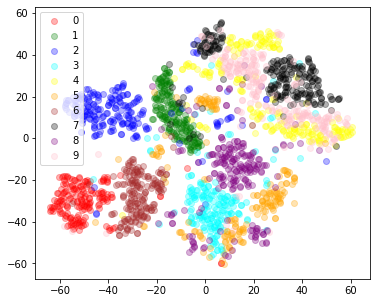

In [10]:
tsne(x_dev1[:2000], ids_dev1[:2000])

### Tsne by mnist digit indentity, rowspace

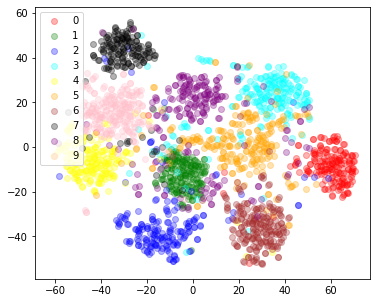

In [19]:
P_rowspace = np.eye(784) - P
w_concat = np.concatenate(Ws[:])
P_concat = inlp.get_rowspace_projection(w_concat)
tsne(P_concat.dot(x_dev1.T).T[:2000], ids_dev1[:2000])

In [20]:
assert np.allclose(P_rowspace, P_concat)

### Tsne by mnist digit identity, concat-rowspace

In [21]:
#tsne(P_concat.dot(x_dev1.T).T[:2000], ids_dev1[:2000])

### Tsne by mnist digit indentity, nullspace

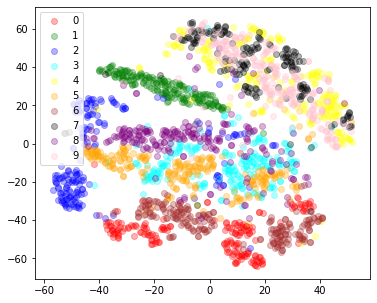

In [22]:
tsne(P.dot(x_dev1.T).T[:2000], ids_dev1[:2000])